# 🌍 Earthquake Prediction Project 🌐

---

## 📊 Overview

This project aims to build a machine learning-based **Earthquake Prediction System** using historical earthquake data from India and surrounding territories (2010–2020).
The goal is to analyze seismic patterns and develop a model that can classify earthquake severity or predict key seismic activity features.

The project is divided into the following key steps:
- **Exploratory Data Analysis (EDA)**
- **Feature Engineering**
- **Machine Learning Model Building**
- **Model Evaluation**
- **Deployment (Streamlit App)**

---

## 📂 Dataset Details

- **Source**: [Kaggle - Earthquake Data (India & Surrounding Territory)](https://www.kaggle.com/datasets/narayan63/earthquake-data-india-and-surrounded-territory)
- **Time Range**: 2010 - 2020
- **Region Covered**: India, Nepal, Pakistan, Bangladesh, Bhutan, and surrounding areas
- **Features Include**:
  - `time`, `latitude`, `longitude`, `depth`
  - `magnitude`, `location`
  - Derived Features: `year`, `month`, `weekday`, `region`, `time_of_day`

---

## 🧑‍💻 Models Used

| Model                     | Type           | Notes                              |
|---------------------------|----------------|-------------------------------------|
| **Linear Regression**      | Regression     | Simple baseline model               |
| **Random Forest Regressor**| Regression     | Captures non-linear patterns        |
| **XGBoost Regressor**      | Regression     | Advanced boosting model             |
| **Support Vector Regressor (SVR)** | Regression     | 🔥 **Best performance model**        |

- Multiple models were trained and evaluated.
- **Support Vector Regressor (SVR)** gave the **best results** in terms of prediction accuracy and generalization, and was chosen for final deployment.
- Features were selected based on **correlation analysis** and **mutual information** techniques.
- Evaluation metrics used: **Mean Absolute Error (MAE)**, **Root Mean Squared Error (RMSE)**, and **R² Score**.


---

## 🎯 Objective

- **Predict** the severity category (e.g., Low, Moderate, High) of earthquakes based on seismic features.
- Enable easy **deployment** via a web app using Streamlit.
- Provide an interactive and informative interface for end users.

---

## 🚀 Final Deliverables

- **Colab Notebook**: Full EDA + Model Training + Evaluation
- **Trained Model (.pkl file)**: Ready for deployment
- **Streamlit App**: User-friendly web application
- **README & Documentation**: For project presentation

---

> 📢 *Note*: This project is for academic and demonstration purposes only. It is **not** a substitute for official earthquake early warning systems.


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.pipeline import Pipeline
import joblib
from sklearn.preprocessing import PowerTransformer, StandardScaler, LabelEncoder
from sklearn.feature_selection import chi2, SelectKBest, mutual_info_classif
from statsmodels.stats.outliers_influence import variance_inflation_factor
import matplotlib.pyplot as plt
import seaborn as sns


In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("narayan63/earthquake-data-india-and-surrounded-territory")

print("Path to dataset files:", path)

Path to dataset files: /root/.cache/kagglehub/datasets/narayan63/earthquake-data-india-and-surrounded-territory/versions/1


In [ ]:
import pandas as pd

df = pd.read_csv( "/content/riseq.csv")

# Quick check
df.head()

,orginal_time,latitude,longitude,depth,magnitude,location
0,2010-01-01 02:08:21 UTC,26.31,99.74,10.0,5.0[MB],"345km ESE of Changlang, Arunachal Pradesh, India"
1,2010-01-01 02:22:25 UTC,30.44,83.71,10.0,4.8[MB],"341km NNW of Kathmandu, Nepal"
2,2010-01-01 02:42:50 UTC,29.15,80.61,10.0,2.5[ML],"61km SE of Pithoragarh, Uttarakhand, India"
3,2010-01-01 17:42:03 UTC,1.40,67.75,10.0,4.7[MB],"710km WSW of Male, Maldives"
4,2010-01-02 02:15:07 UTC,38.29,71.00,38.0,5.4[MB],"138km NNE of Fayzabad, Afghanistan"


In [ ]:
# if any duplicate rows?
print(f"Duplicate rows: {df.duplicated().sum()}")

Duplicate rows: 4


In [ ]:
# 1. Remove Duplicates
df = df.drop_duplicates()

In [ ]:
df['magnitude'] = df['magnitude'].str.replace(r'\[.*\]', '', regex=True).astype(float)


In [ ]:
df['orginal_time'] = pd.to_datetime(df['orginal_time'].str.replace(" UTC", ""), errors='coerce')


In [ ]:
df[['distance', 'direction', 'place']] = df['location'].str.extract(r'(\d+\.?\d*)km\s([A-Za-z]+)\sof\s(.+)')


In [ ]:
df['year'] = df['orginal_time'].dt.year
df['month'] = df['orginal_time'].dt.month
df['day'] = df['orginal_time'].dt.day
df['hour'] = df['orginal_time'].dt.hour
df['weekday'] = df['orginal_time'].dt.weekday
df['is_weekend'] = df['weekday'].isin([5, 6]).astype(int)

In [ ]:
# 6. Time of Day Feature
def get_time_of_day(hour):
    if 5 <= hour < 12:
        return 'Morning'
    elif 12 <= hour < 17:
        return 'Afternoon'
    elif 17 <= hour < 21:
        return 'Evening'
    else:
        return 'Night'

df['time_of_day'] = df['hour'].apply(get_time_of_day)

In [ ]:
# 7. Region Mapping from 'place'
def map_region(place):
    place = str(place).lower()
    if 'india' in place:
        return 'India'
    elif 'nepal' in place:
        return 'Nepal'
    elif 'pakistan' in place:
        return 'Pakistan'
    elif 'afghanistan' in place:
        return 'Afghanistan'
    elif 'bangladesh' in place:
        return 'Bangladesh'
    elif 'myanmar' in place:
        return 'Myanmar'
    else:
        return 'Other'

df['region'] = df['place'].apply(map_region)


In [ ]:
# 8. Power Transformation (Yeo-Johnson) for 'magnitude' and 'depth'
pt = PowerTransformer(method='yeo-johnson')
df[['magnitude_transformed', 'depth_transformed']] = pt.fit_transform(df[['magnitude', 'depth']])

In [ ]:
# 9. Cyclical Encoding for hour, month, weekday
df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)

df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)

df['weekday_sin'] = np.sin(2 * np.pi * df['weekday'] / 7)
df['weekday_cos'] = np.cos(2 * np.pi * df['weekday'] / 7)

In [ ]:
# 10. Magnitude Binning
bins = [0, 3.9, 4.9, 5.9, 6.9, np.inf]
labels = ['Minor', 'Light', 'Moderate', 'Strong', 'Major']
df['magnitude_bin'] = pd.cut(df['magnitude'], bins=bins, labels=labels)

In [ ]:
# 11. Depth Binning
depth_bins = [0, 70, 300, np.inf]
depth_labels = ['Shallow', 'Intermediate', 'Deep']
df['depth_bin'] = pd.cut(df['depth'], bins=depth_bins, labels=depth_labels)

In [ ]:
# 12. Interaction Feature (Magnitude * Depth)
df['mag_depth_interaction'] = df['magnitude'] * df['depth']

In [ ]:
# 13. Encode 'time_of_day'
time_order = {'Night': 0, 'Morning': 1, 'Afternoon': 2, 'Evening': 3}
df['time_of_day_encoded'] = df['time_of_day'].map(time_order)

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128279 (\N{LINK SYMBOL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


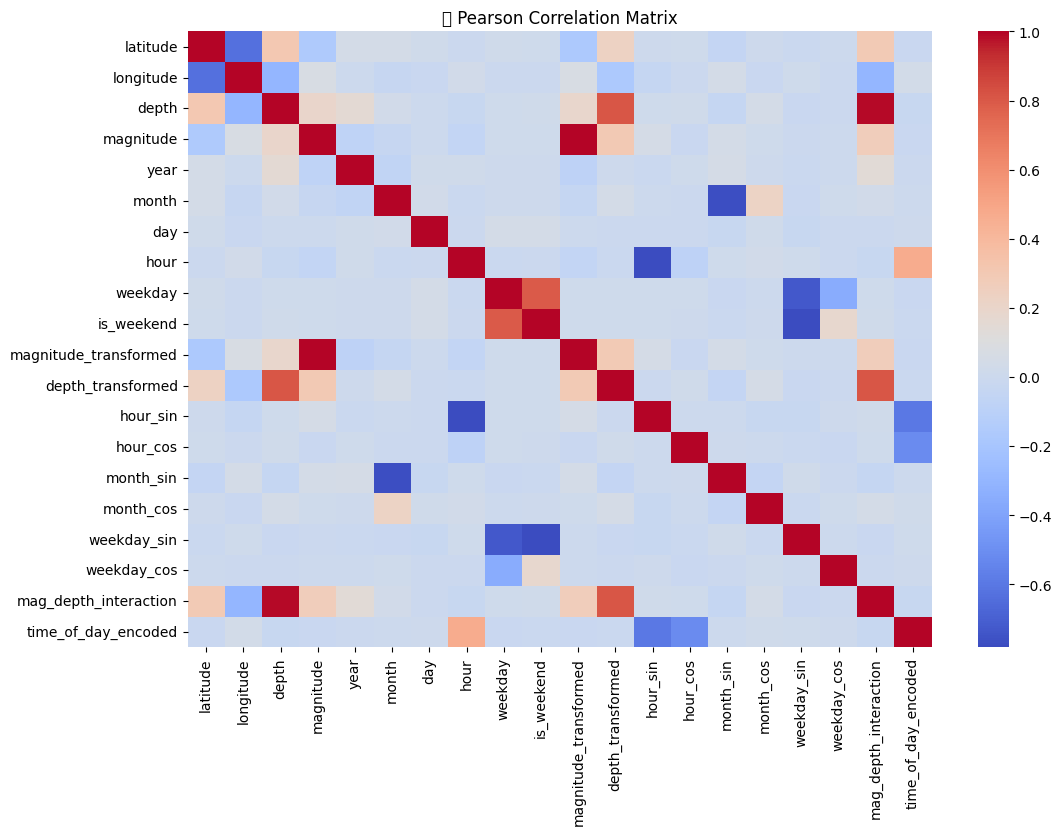

In [ ]:
# 14. Correlation Matrix (Numerical Features)
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
corr_matrix = df[num_cols].corr()
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, cmap='coolwarm', annot=False)
plt.title('🔗 Pearson Correlation Matrix')
plt.show()


In [ ]:
# 15. VIF (Variance Inflation Factor)
X = StandardScaler().fit_transform(df[num_cols])
X_df = pd.DataFrame(X, columns=num_cols)

vif_data = pd.DataFrame()
vif_data["feature"] = X_df.columns
vif_data["VIF"] = [variance_inflation_factor(X_df.values, i) for i in range(X_df.shape[1])]

print("\n🔎 Variance Inflation Factors:")
print(vif_data.sort_values(by="VIF", ascending=False))


🔎 Variance Inflation Factors:
                  feature         VIF
10  magnitude_transformed  495.634936
3               magnitude  485.289980
2                   depth   83.106161
18  mag_depth_interaction   81.659754
8                 weekday    9.022812
9              is_weekend    8.642642
12               hour_sin    3.779651
17            weekday_cos    3.329891
11      depth_transformed    3.328484
16            weekday_sin    2.829311
5                   month    2.691405
19    time_of_day_encoded    2.669403
7                    hour    2.595365
14              month_sin    2.565306
0                latitude    1.876923
1               longitude    1.756377
13               hour_cos    1.745169
4                    year    1.105159
15              month_cos    1.097748
6                     day    1.005319


In [ ]:
# 16. Chi-Square Test (Categorical Features vs Magnitude Bin)
cat_cols = ['region', 'time_of_day', 'place']
encoded_df = df[cat_cols].apply(LabelEncoder().fit_transform)

chi2_selector = SelectKBest(chi2, k='all')
chi2_selector.fit(encoded_df, df['magnitude_bin'])

chi2_scores = pd.Series(chi2_selector.scores_, index=encoded_df.columns).sort_values(ascending=False)
print("\n📊 Chi-Square Scores (Categorical vs Magnitude_bin):")
print(chi2_scores)


📊 Chi-Square Scores (Categorical vs Magnitude_bin):
place          11251.223558
region           147.267454
time_of_day        1.245009
dtype: float64


In [ ]:
# 17. Mutual Information (Numerical + Encoded Categorical vs Magnitude Bin)
combined_df = pd.concat([encoded_df, df[num_cols]], axis=1)
mi_scores = mutual_info_classif(combined_df, df['magnitude_bin'], random_state=42)
mi_series = pd.Series(mi_scores, index=combined_df.columns).sort_values(ascending=False)
print("\n📈 Mutual Information Scores:")
print(mi_series)


📈 Mutual Information Scores:
magnitude                0.966709
magnitude_transformed    0.966653
mag_depth_interaction    0.540552
place                    0.209353
latitude                 0.154029
longitude                0.106007
depth                    0.062387
region                   0.059029
depth_transformed        0.055908
year                     0.024127
weekday                  0.013441
month                    0.012217
month_sin                0.007459
hour_sin                 0.006901
day                      0.005452
hour                     0.003744
month_cos                0.000875
time_of_day              0.000417
hour_cos                 0.000107
is_weekend               0.000000
weekday_sin              0.000000
weekday_cos              0.000000
time_of_day_encoded      0.000000
dtype: float64


#Model Building - SVR

In [ ]:
# 1. Select Features and Target
features = [
    'latitude', 'longitude', 'depth', 'mag_depth_interaction',
    'depth_transformed', 'hour_sin', 'hour_cos',
    'month_sin', 'month_cos', 'weekday_sin', 'weekday_cos',
    'is_weekend', 'time_of_day_encoded'
]
target = 'magnitude'

X = df[features]
y = df[target]



In [ ]:
# 2. Split Train-Test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 3. Build Pipeline with Scaling + SVR
svr_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('svr', SVR())
])

In [ ]:
# 4. Hyperparameter Grid for SVR
param_grid = {
    'svr__kernel': ['rbf'],
    'svr__C': [1, 10, 100],
    'svr__epsilon': [0.1, 0.2, 0.5],
    'svr__gamma': ['scale', 'auto']
}


In [ ]:
# 5. Grid Search CV
grid_search = GridSearchCV(svr_pipeline, param_grid, cv=5, scoring='r2', n_jobs=-1)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('svr', SVR())]),
             n_jobs=-1,
             param_grid={'svr__C': [1, 10, 100],
                         'svr__epsilon': [0.1, 0.2, 0.5],
                         'svr__gamma': ['scale', 'auto'],
                         'svr__kernel': ['rbf']},
             scoring='r2')

In [ ]:
# Ensure X_test is a DataFrame with the same columns as the training data
X_test = X_test[features]  # Ensure only the required features are passed

# Now, make predictions using the trained model
y_pred = best_model.predict(X_test)

# Evaluate model performance
print("Predicted Magnitudes:", y_pred)

Predicted Magnitudes: [2.76845574 2.01731484 3.21828322 ... 4.37641269 3.81953998 3.36726174]


In [ ]:
# 6. Best Model
best_model = grid_search.best_estimator_

In [ ]:
# 7. Predictions
y_pred = best_model.predict(X_test)

In [ ]:
# 8. Evaluation
print("🔎 Best Parameters:", grid_search.best_params_)
print("📊 R2 Score:", r2_score(y_test, y_pred))
print("📉 RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))
print("📈 MAE:", mean_absolute_error(y_test, y_pred))

🔎 Best Parameters: {'svr__C': 100, 'svr__epsilon': 0.1, 'svr__gamma': 'auto', 'svr__kernel': 'rbf'}
📊 R2 Score: 0.9627724752338342
📉 RMSE: 0.15461475652863144
📈 MAE: 0.0982780721842536


#New Model with Important features


In [ ]:
# Features you want to keep
features = ['latitude', 'longitude', 'depth', 'direction', 'time_of_day', 'region', 'hour', 'month']

In [ ]:
# Encode categorical features
df['direction_encoded'] = LabelEncoder().fit_transform(df['direction'].astype(str))
df['time_of_day_encoded'] = df['time_of_day'].map({'Night': 0, 'Morning': 1, 'Afternoon': 2, 'Evening': 3})
df['region_encoded'] = LabelEncoder().fit_transform(df['region'].astype(str))

In [ ]:
# Final selected features
selected_features = [
    'latitude', 'longitude', 'depth',
    'direction_encoded', 'time_of_day_encoded', 'region_encoded',
    'hour', 'month'
]

In [ ]:
X = df[selected_features]
y = df['magnitude']


In [ ]:
# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Build pipeline
svr_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('svr', SVR())
])

In [ ]:
# Hyperparameter Grid
param_grid = {
    'svr__kernel': ['rbf'],
    'svr__C': [1, 10, 100],
    'svr__epsilon': [0.1, 0.2, 0.5],
    'svr__gamma': ['scale', 'auto']
}

In [ ]:
# Grid Search
grid_search = GridSearchCV(svr_pipeline, param_grid, cv=5, scoring='r2', n_jobs=-1)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('svr', SVR())]),
             n_jobs=-1,
             param_grid={'svr__C': [1, 10, 100],
                         'svr__epsilon': [0.1, 0.2, 0.5],
                         'svr__gamma': ['scale', 'auto'],
                         'svr__kernel': ['rbf']},
             scoring='r2')

In [ ]:
# ✅ Step 8: Best model
best_model = grid_search.best_estimator_

In [ ]:
# ✅ Step 9: Predictions and evaluation
y_pred = best_model.predict(X_test)

print(f"Best Parameters: {grid_search.best_params_}")
print(f"R2 Score: {r2_score(y_test, y_pred):.4f}")
print(f"Mean Squared Error: {mean_squared_error(y_test, y_pred):.4f}")
print(f"Mean Absolute Error: {mean_absolute_error(y_test, y_pred):.4f}")

Best Parameters: {'svr__C': 10, 'svr__epsilon': 0.2, 'svr__gamma': 'auto', 'svr__kernel': 'rbf'}
R2 Score: 0.4449
Mean Squared Error: 0.3564
Mean Absolute Error: 0.4553


In [ ]:
import joblib

# Save the trained SVR pipeline
joblib.dump(grid_search.best_estimator_, 'svr_magnitude.pkl')

print("✅ Model saved as svr_magnitude.pkl")


✅ Model saved as svr_magnitude.pkl
